## PyTorch Workflow Fundamentals

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.3.1+cu118'

Machine learning is a game of two parts:

1.   Turn your data, whatever it is, into numbers (a representation).
2.   Pick or build a model to learn the representation as best as possible.

Let's create our data as a straight line.

## 1. Data (preparing and loading)

In [3]:
# create known parameters

weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))


Beautiful! Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels).

In [4]:
# create train / test split

train_split = int(0.8 * len(X)) # 80% data on training set, 20% on test set

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
# visuvalize the data

def plot_prediction(train_data=X_train, train_label=y_train, test_data=X_test, test_label=y_test, prediction=None):

  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_label, c="b", s=4, label='Training data')

  plt.scatter(test_data, test_label, c="g", s=4, label='Testing data')

  if prediction is not None:
    plt.scatter(test_data, prediction, c="r", s=4, label='Predictions')

  plt.legend(prop={"size": 14})

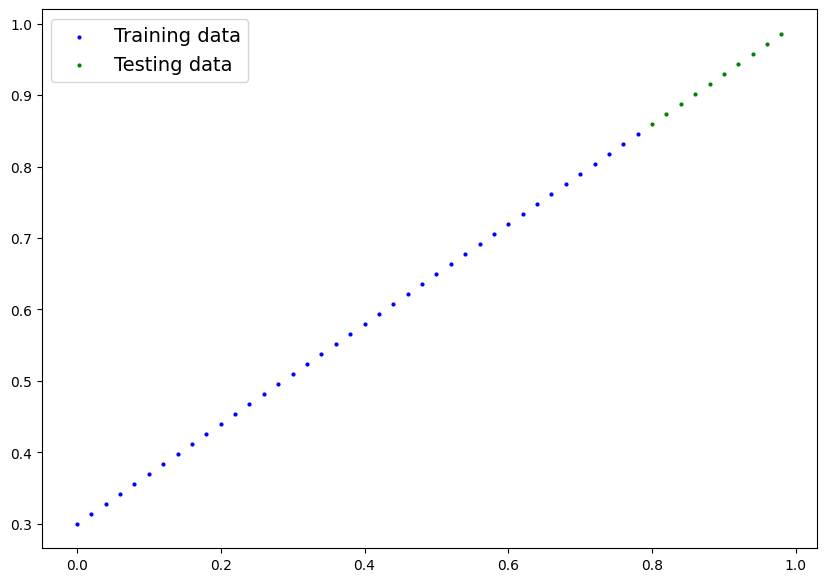

In [6]:
plot_prediction()

## 2. Build Model

In [7]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias  # y = m*x + b


## Checking the contents of a PyTorch model

In [8]:
torch.manual_seed(42)

model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode()`
To check this we can pass it the test data X_test to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.

In [10]:
with torch.inference_mode():
  y_preds = model_0(X_test)

**Note**: In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things, `torch.inference_mode()` is newer, potentially faster and preferred.

In [11]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

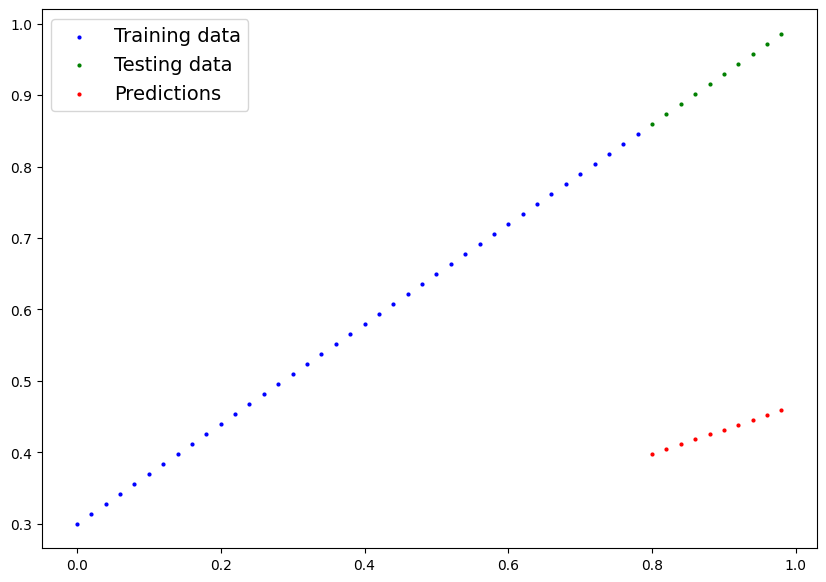

In [12]:
plot_prediction(prediction=y_preds)

In [13]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train model

### Creating a loss function and optimizer in PyTorch:

In [14]:
# create the loss function
loss_fn = nn.L1Loss() # MAE is same as L1loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),  # parameters of target model to optimize
                            lr=0.01)

### Creating an optimization loop in PyTorch

#### Let's put all of the above together and train our model for 100 epochs (forward passes through the data) and we'll evaluate it every 10 epochs.

In [15]:
torch.manual_seed(42)

epochs = 100

train_loss_value = []
test_loss_value = []
epoch_count = []

for epoch in range(epochs):

  ### Training

  # Put model in training mode (this is the default state of a model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():

    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_value.append(loss.detach().numpy())
      test_loss_value.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss : {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss : 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss : 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss : 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss : 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss : 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss : 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss : 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss : 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss : 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss : 0.06473556160926819


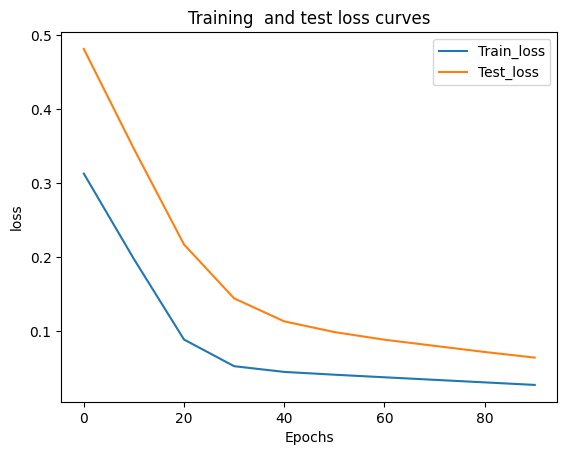

In [16]:
# Plot the loss curve

plt.plot(epoch_count, train_loss_value, label='Train_loss')
plt.plot(epoch_count, test_loss_value, label='Test_loss')

plt.title("Training  and test loss curves")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [17]:
# Find our model's learned parameters

model_0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [18]:
# original weight and bias

print(f"weight: {weight}, bias:{bias}")

weight: 0.7, bias:0.3


### let's run 200 epochs

In [19]:


torch.manual_seed(42)

epochs = 200

train_loss_value = []
test_loss_value = []
epoch_count = []

for epoch in range(epochs):

  ### Training

  # Put model in training mode (this is the default state of a model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():

    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_value.append(loss.detach().numpy())
      test_loss_value.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss : {test_loss}")

Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss : 0.05646304413676262
Epoch: 10 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss : 0.04819049686193466
Epoch: 20 | MAE Train Loss: 0.01758546568453312 | MAE Test Loss : 0.04060482233762741
Epoch: 30 | MAE Train Loss: 0.014155393466353416 | MAE Test Loss : 0.03233227878808975
Epoch: 40 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss : 0.024059748277068138
Epoch: 50 | MAE Train Loss: 0.0072835334576666355 | MAE Test Loss : 0.016474086791276932
Epoch: 60 | MAE Train Loss: 0.0038517764769494534 | MAE Test Loss : 0.008201557211577892
Epoch: 70 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss : 0.005023092031478882
Epoch: 80 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss : 0.005023092031478882
Epoch: 90 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss : 0.005023092031478882
Epoch: 100 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss : 0.005023092031478882
Epoch: 110 | MAE Train Loss: 0.0089

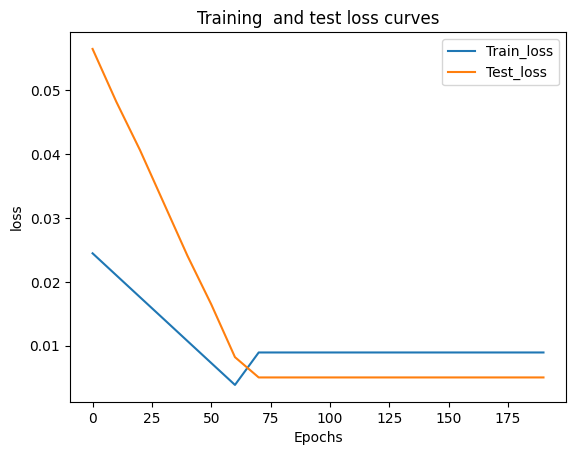

In [20]:
plt.plot(epoch_count, train_loss_value, label='Train_loss')
plt.plot(epoch_count, test_loss_value, label='Test_loss')

plt.title("Training  and test loss curves")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## 4. Making predictions with a trained PyTorch model (inference)

In [21]:
model_0.eval()

with torch.inference_mode():

  y_pred = model_0(X_test)


y_pred

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

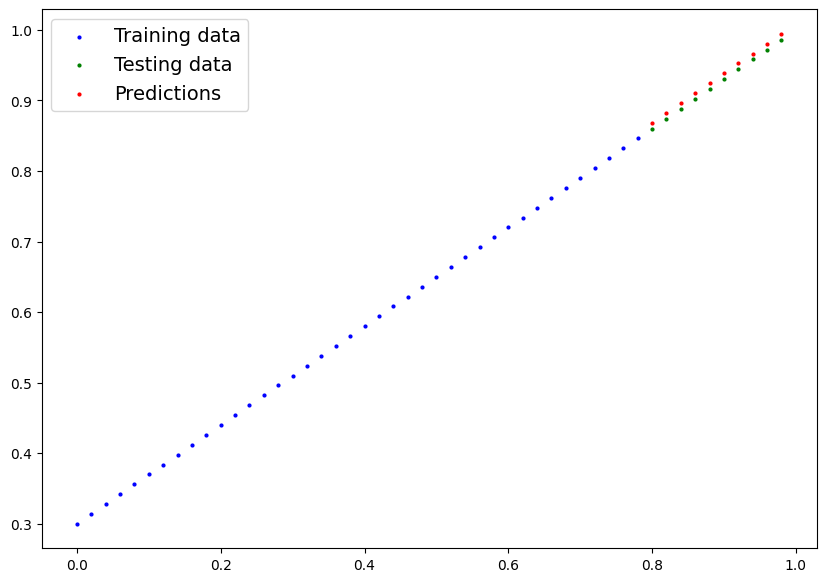

In [22]:
plot_prediction(prediction=y_pred)

## 5. Saving and loading a PyTorch model

In [23]:
from pathlib import Path

In [24]:
# create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"Model save path {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Model save path models\01_pytorch_workflow_model_0.pth


In [25]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 Giridaran Administrators 1680 Oct 15 14:47 models/01_pytorch_workflow_model_0.pth


Saving a PyTorch model's `state_dict()`
The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

We'll create a directory for saving models to called models using Python's pathlib module.
We'll create a file path to save the model to.
We'll call torch.save(obj, f) where obj is the target model's `state_dict()` and f is the filename of where to save the model.
Note: It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.

Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict() `at models/01_pytorch_workflow_model_0.pth we can now load it in using torch.nn.Module.`load_state_dict(torch.load(f))` where f is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's state_dict() which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

Why not save the entire model?

Saving the entire model rather than just the `state_dict() `is more intuitive, however, to quote the PyTorch documentation (italics mine):

The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...

Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of torch.nn.Module and will hence have the in-built method `load_state_dict()`.

In [26]:
loaded_model_0 = LinearRegression()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [27]:
loaded_model_0.eval()


with torch.inference_mode():
  loaded_model_pred = loaded_model_0(X_test)

In [28]:
y_pred == loaded_model_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

We've covered a fair bit of ground so far.

But once you've had some practice, you'll be performing the above steps like dancing down the street.

Speaking of practice, let's put everything we've done so far together.

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

There'll be far less commentary in this section than above since what we're going to go through has already been covered.

We'll start by importing the standard libraries we need.


In [29]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.1+cu118'

In [30]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [31]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

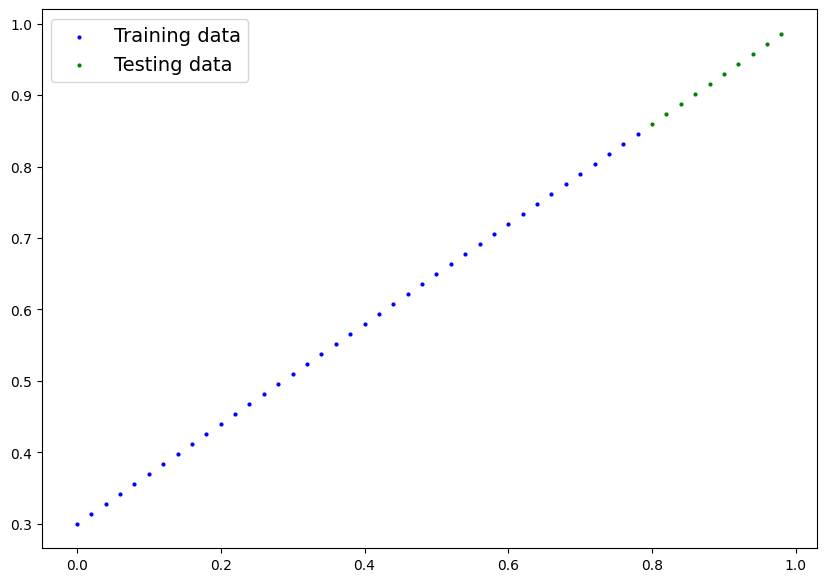

In [33]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_prediction(X_train, y_train, X_test, y_test)

In [34]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using `.to(device)`.

First let's check the model's current device

In [35]:
next(model_1.parameters()).device

device(type='cpu')

Wonderful, looks like the model's on the CPU by default.

Let's change it to be on the GPU (if it's available).

In [36]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [37]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

Beautiful, loss function and optimizer ready, now let's train and evaluate our model using a training and testing loop.

The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target device.

We've already put our model on the target device using `model_1.to(device)`.

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set `epochs=1000`.

In [38]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [39]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making predictions

In [40]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

If you're making predictions with data on the GPU, you might notice the output of the above has device='cuda:0' towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.

**Note**: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call .cpu() on your target tensor to return a copy of your target tensor on the CPU.

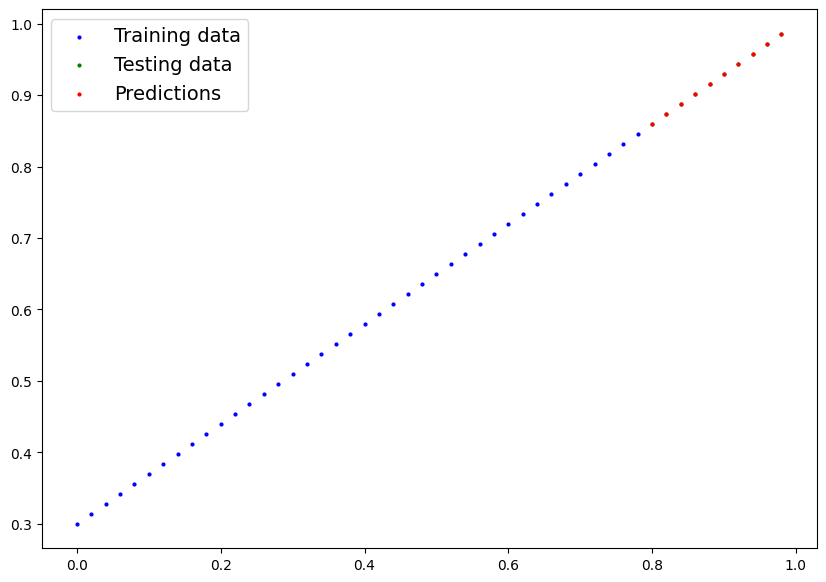

In [41]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_prediction(prediction=y_preds.cpu())

## Saving and loading a model

In [42]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


And just to make sure everything worked well, let's load it back in.

We'll:

Create a new instance of the LinearRegressionModelV2() class

Load in the model state dict using torch.nn.Module.load_state_dict()

Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [43]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

loaded_model_1

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [44]:
for i in loaded_model_1.parameters():
  print(i)

Parameter containing:
tensor([[0.6968]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.3025], device='cuda:0', requires_grad=True)


In [45]:
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_pred = loaded_model_1(X_test)

y_preds == loaded_model_1_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

# Exercise

In [135]:
import numpy as np

In [136]:
def stright_line(x):
  return (0.3 * x) + 0.9

In [137]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 100
step = 1

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = stright_line(X)
X[:10], y[:10]

(tensor([[0],
         [1],
         [2],
         [3],
         [4],
         [5],
         [6],
         [7],
         [8],
         [9]]),
 tensor([[0.9000],
         [1.2000],
         [1.5000],
         [1.8000],
         [2.1000],
         [2.4000],
         [2.7000],
         [3.0000],
         [3.3000],
         [3.6000]]))

In [158]:
# Split data
train_split = int(0.8 * len(X))
X.type(torch.float)
y.type(torch.float)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

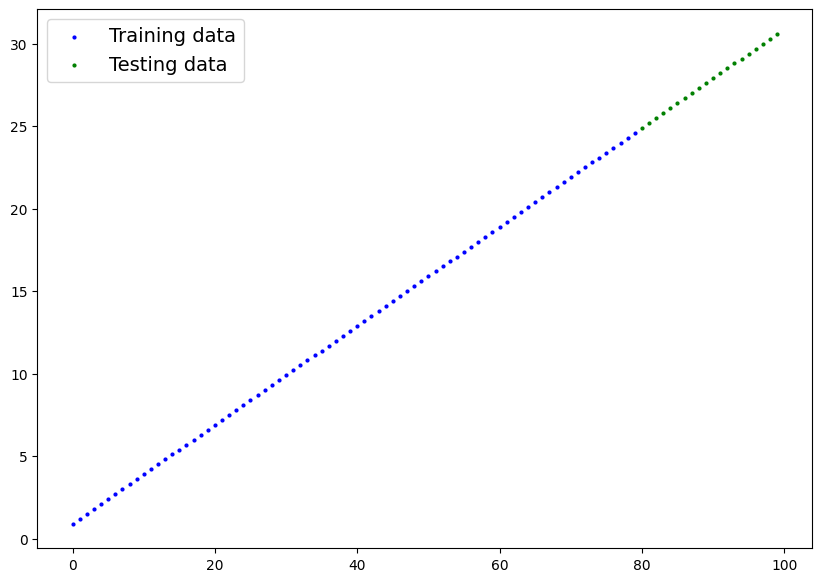

In [159]:
plot_prediction(X_train, y_train, X_test, y_test)

In [160]:
class LinearRegressionModelV3(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        return self.linear_layer(x)


model_2 = LinearRegressionModelV3()
model_2, model_2.state_dict()

(LinearRegressionModelV3(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.5167]])),
              ('linear_layer.bias', tensor([0.1164]))]))

In [161]:
next(model_2.parameters()).device

device(type='cpu')

In [162]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [163]:
model_2.to(device)

LinearRegressionModelV3(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [164]:
next(model_2.parameters()).device

device(type='cuda', index=0)

In [178]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_2.parameters(), 
                            lr=0.0001)

In [179]:
epochs = 1000

X_train = X_train.type(torch.float).to(device)
X_test = X_test.type(torch.float).to(device)
y_train = y_train.type(torch.float).to(device)
y_test = y_test.type(torch.float).to(device)

for epoch in range(epochs):

    model_2.train()

    y_pred = model_2(X_train)

    train_loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_2.eval()


    with torch.inference_mode():
        test_pred = model_2(X_test)

        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.6017593741416931 | Test loss: 0.6980018615722656
Epoch: 20 | Train loss: 0.10257747024297714 | Test loss: 0.15500564873218536
Epoch: 40 | Train loss: 0.10221781581640244 | Test loss: 0.14152804017066956
Epoch: 60 | Train loss: 0.10185867547988892 | Test loss: 0.14013318717479706
Epoch: 80 | Train loss: 0.1014997735619545 | Test loss: 0.13873815536499023
Epoch: 100 | Train loss: 0.10114085674285889 | Test loss: 0.13734321296215057
Epoch: 120 | Train loss: 0.10078199207782745 | Test loss: 0.13594818115234375
Epoch: 140 | Train loss: 0.10057299584150314 | Test loss: 0.1477590650320053
Epoch: 160 | Train loss: 0.10008006542921066 | Test loss: 0.1463642120361328
Epoch: 180 | Train loss: 0.09973512589931488 | Test loss: 0.14496926963329315
Epoch: 200 | Train loss: 0.09939023107290268 | Test loss: 0.14357434213161469
Epoch: 220 | Train loss: 0.09917741268873215 | Test loss: 0.13009671866893768
Epoch: 240 | Train loss: 0.09880506992340088 | Test loss: 0.128701791167259

In [180]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3044]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.6951], device='cuda:0'))])

In [181]:
print(weight, bias)

0.7 0.3


In [190]:
model_2.eval()

with torch.inference_mode():
    y_test_pred = model_2(X_test)

y_test_pred = y_test_pred.to('cpu')

In [191]:
y_test_pred.device

device(type='cpu')

In [193]:
X_train, y_train, X_test, y_test = X_train.to('cpu'), y_train.to('cpu'), X_test.to('cpu'), y_test.to('cpu')

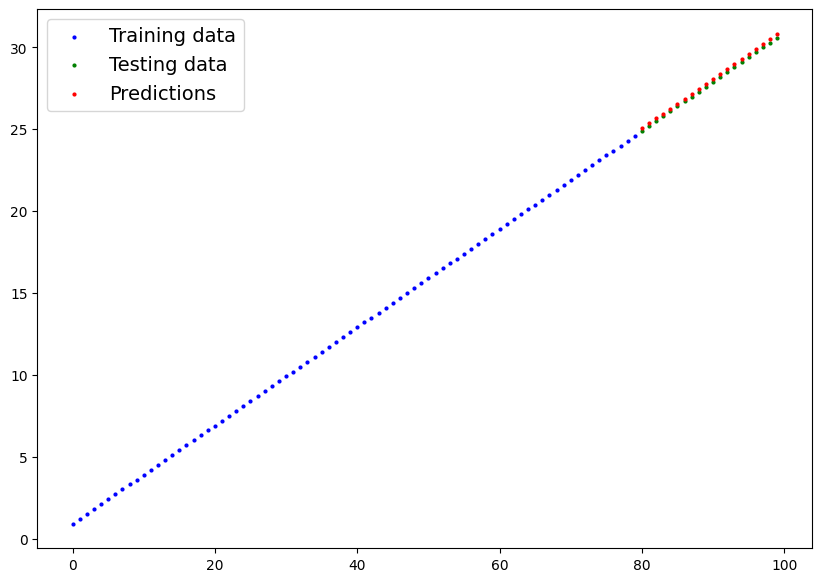

In [194]:
plot_prediction(X_train, y_train, X_test, y_test, y_test_pred)

In [195]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saved path : {MODEL_SAVE_PATH}")

torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

saved path : models\model_2.pth


In [198]:
loaded_model_2 = LinearRegressionModelV3()

loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_2.to(device)
loaded_model_2

LinearRegressionModelV3(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [203]:
loaded_model_2.eval()

with torch.inference_mode():
     loaded_model_pred = loaded_model_2(X_test.to(device))

In [207]:
loaded_model_pred.to('cpu') == y_test_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])